# Wrangle Exercises

 <tr>
    <td> <img src="sieuwert-otterloo-aren8nutd1Q-unsplash-2.jpg"/> </td>
    <td> <img src="webaliser-_TPTXZd9mOo-unsplash.jpg"/> </td>
    </tr>

[Source Photo 1](https://unsplash.com/photos/aren8nutd1Q) 
[Source Photo 2](https://unsplash.com/photos/_TPTXZd9mOo)

## Background

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

## Import Libraries

First we will import the necessary libraries.

In [1]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for processing data
import pandas as pd
import numpy as np

#Import libraries for graphing
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for obtaining data from SQL databse
import env
import os

#Library for dealing with NA values
from sklearn.impute import SimpleImputer

## Acquire data

Acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the `zillow` database for all 'Single Family Residential' properties.

#### Note

The `fips` column indicates the FIPS county code (Federal Information Processing Standards) is a five digit code which indicates the county in which a property is located. In this case, we have three FIPS code. All of these three codes indicate coastal Southern California counties. The counties indicated by these FIPS codes are:
 - 6037: Los Angeles County, <img src = "sterling-davis-4iXagiKXn3Y-unsplash.jpg"/>
 - 6059: Orange County, <img src="derek-liang-N61-GGQAp6Y-unsplash.jpg"/>
 - 6111: Ventura County. <img src = "pexels-isaac-taylor-1541218.jpg"/>
[Source Photo 3](https://unsplash.com/photos/4iXagiKXn3Y) 
[Source Photo 4](https://unsplash.com/photos/N61-GGQAp6Y)
[Source Photo 5](https://www.pexels.com/photo/view-of-houses-on-shore-1541218/) 

### Connect to SQL server

The following function allows us to use our `env.py` file to connect to the SQL database. To use this function, you will need to have your own `env` file, housing your username, password, and host name. My `env.py` file is hidden for privacy reasons.

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
     We establish a connection to the SQL database, using my information stored in the env file.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

### Acquire the data

The following function acquires data from the SQL server and puts that data into a pandas DataFrame. 

This project specifies that we are only looking at properties listed in 2017, so in our SQL query, we pull data from the table `properties_2017`. In the SQL query, we also join the table `propertylandusetype`. We join this table because specified earlier that we only want to look at single-family homes. The `propertylandusetype` has a column `propertylandusetypeid`. We indicated in our SQL query that we want only properties with `propertylandusetypeid = 261`. The code for single-family homes is 261.

In [3]:
def get_zillow_data():
    '''
    We will read a SQL query and create a file based on this query.
    '''
    filename = "zillow.csv"
    ##We will write a SQL query to obtain the data
    sql = ''' 
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
         taxvaluedollarcnt, yearbuilt, taxamount, fips FROM properties_2017
    JOIN propertylandusetype
    ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
    AND propertylandusetype.propertylandusetypeid = 261 
    '''
    ##If the file already exists we will simply pull the file.
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    ##If the file does not exist, we run the SQL query again and create a new DataFrame.
    else:
        df = pd.read_sql(sql, get_connection('zillow'))
        return df

Now we will run the function defined above to pull the Zillow data into a pandas DataFrame.

In [4]:
df = get_zillow_data()

### Sample and Summarize data

We will look at the DataFrame we just created. Let's start by looking at the head of the table.

In [5]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


Right away, we notice that this table has many null values. We will now display the shape of the data.

In [6]:
df.shape

(2152863, 7)

This table has 2,152,863 rows and 7 columns. We will now display summary statistics for our DataFrame.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86
fips,2152863.0,6048.377335,20.433292,6037.00,6037.00,6037.00,6059.00,6111.00


We notice from our summary statistics that most of our columns has a very wide range. For example, our properties range from 0 bedrooms up to 25 total bedrooms. This may mean that we have outliers in the data that we should eliminate. We will determine later on if the data indeed has outliers.

Now we will get the DataFrame's info.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


All of our columns have the datatype `float64`.

### Acquire and Summarize Takeaways
 - Our DataFrame has 2,152,863 rows and 7 columns.
 - All of our columns are in the `float64` datatype.
 - The data columns have a wide range of values. This may indicate that the data contains outliers.

## Prepare the Data

Recall from our Acquire stage that the DataFrame has many `NaN` values. Thus, in the Prepare stage we will need to find a way to either replace or eliminate the null values.

### Finding Null Values

We will start out by finding the total number of null values for each column in our DataFrame. If there are a small number of null values, we may simply be able to drop the null values.

In [9]:
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

All of our columns except for `fips` has null values. There are so many null values, simply dropping the null values will damage our analysis. For example, the `yearbuilt` column has 9,337 null values. We cannot simply drop 9,337 rows woth of data! Thus, we will need to find a way to replace the null values in these columns. This leads us to the imputation transformer below.

### Impute Null Values

We will use the imputation transformer to fill the missing values in our DataFrame. We will use the imputation transformer with strategy set to 'mean'.
```python 
strategy='mean' 
``` 
This transformer takes the mean of each column and uses that mean value to replace every `NaN` null value in the column. We will create a for loop to run through each column in our `df` DataFrame, replacing every `NaN` null value with the mean value for that column.

In [10]:
#We will use the mean imputer function.
imputer = SimpleImputer(strategy='mean')

#We will create a for loop that will impute all the null values in each one of our columns.
for col in df.columns:
    df[[col]] = imputer.fit_transform(df[[col]])

#Now we will check the amount of null values in each column.
df.isnull().sum()      

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

We have successfully eliminate all our `NaN` null values. We can now move on to the next step of preparing our function, removing outliers.

### Eliminate Outliers

Recall from the Acquire stage that when we ran summary statistics of our `df` DataFrame, we saw that the data in each column has a wide range. This indicates to us that there may be outliers in the data.

The following `remove_outliers` function will
 1. detect outliers in the DataFrame, and
 2. remove outliers from our DataFrame, if detected. 
    
We can choose a `k` value. The higher the `k` value, we choose, the more outliers we keep. We usually choose a `k` value in the range of 1.5 through 3. 

In [11]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

Now we are ready to run the `remove_outliers` function on our data. Since I would rather keep more outliers, I will use the `k` value of 3. 

In [12]:
df = remove_outliers(df, 3, df.columns)

We will now run the summary statistics on our DataFrame again to see how the ranges have changed after eliminating the outliers.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2047697.0,3.257585,0.867531,1.00,3.00,3.00,4.0,6.0
bathroomcnt,2047697.0,2.144195,0.816078,0.00,2.00,2.00,3.0,5.5
calculatedfinishedsquarefeet,2047697.0,1753.956279,706.216229,1.00,1245.00,1593.00,2116.0,4965.0
taxvaluedollarcnt,2047697.0,373754.528423,263037.278085,1.00,183073.00,315734.00,499089.0,1521121.0
yearbuilt,2047697.0,1960.342414,21.565934,1875.00,1949.00,1958.00,1974.0,2016.0
taxamount,2047697.0,4615.385399,3013.713983,16.48,2477.34,3973.52,6015.1,16770.6
fips,2047697.0,6048.426256,20.519644,6037.00,6037.00,6037.00,6059.0,6111.0


The range of values within columns has significantly decreased. For example, whereas before eliminating outliers the bedroom count ranges from 0 to 25, after eliminating outliers, the bedroom count now ranges from 1 to 6. 

### Prepare Takeaways
 - We have replaced every null value in the DataFrame.
 - We have eliminated the most extreme outliers.  
 - Our DataFrame is now ready for us to explore.

## Visualize Distributions

We will plot the data to see the distributions of single variables and check for skewness, outliers, and unit scales. 

Since we are exploring single variables, we do not need to split our data.

### Bedroom Count Distribution

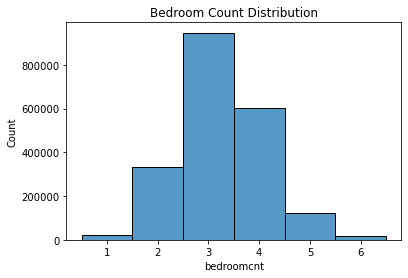

In [17]:
bedroom_count = sns.histplot(data=df, x="bedroomcnt", discrete = True).set(Title = "Bedroom Count Distribution")

### Bathroom Count Distribution

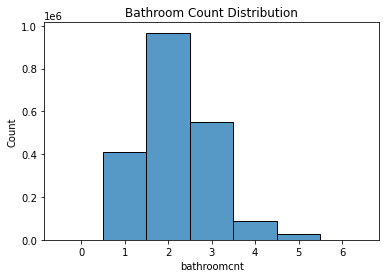

In [18]:
bathroom_count = sns.histplot(data=df, x="bathroomcnt", discrete = True).set(Title = "Bathroom Count Distribution")

### Square Feet Distribution

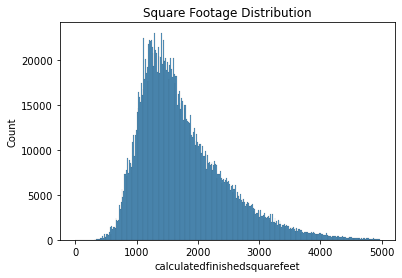

In [19]:
square_feet_log_scale = sns.histplot(data=df, x="calculatedfinishedsquarefeet").set(Title = "Square Footage Distribution")

### Tax Value Distribution

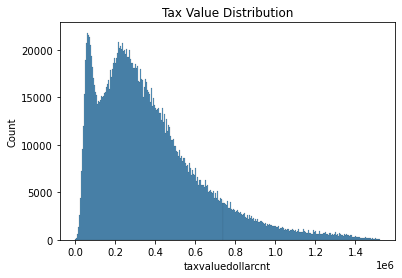

In [20]:
tax_value = sns.histplot(data = df, x = "taxvaluedollarcnt").set(Title = "Tax Value Distribution")

### Year Built Distribution

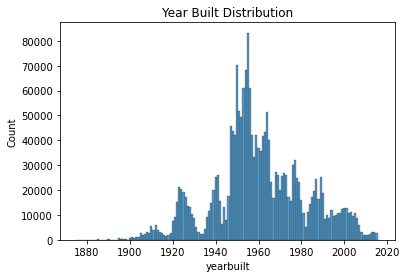

In [21]:
yearbuilt_graph = sns.histplot(data=df, x="yearbuilt", discrete = True).set(Title = "Year Built Distribution")

### FIPS Code Distribution

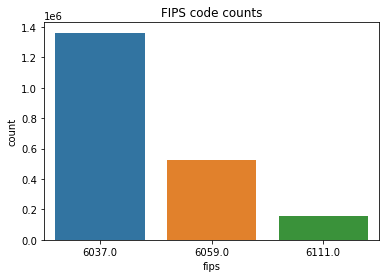

In [22]:
fips_graph = sns.countplot(data =df, x ="fips").set(Title = "FIPS code counts")

![title](ralph-ravi-kayden-2d4lAQAlbDA-unsplash.jpg)

[Source Photo 6](https://unsplash.com/photos/2d4lAQAlbDA)